### DTSA 5511 Introduction to Deep Learning - Mini Project 1
Project Title: Histopathologic Cancer Detection:  CNN+ANN vs. CNN+SVM <br>
Date: 2023 Nov 16 <br>
Author: Tsai-Yun Li <br>
Course Lecturer: Geena Kim <br>
Orginzation: University of Colorado Boulder <br>
Kaggle Competition Name: Histopathologic Cancer Detection <br>
GitHub Repository Link: https://github.com/TsaiYunLi/ML3_Miniporj1_TsaiYunLi

### Table of Contents
1. Problem Description
2. Data Description
3. Exploratory Data Analysis (EDA) <br>
3.1 EDA for the Dataframe of the Training Dataset <br>
3.2 EDA for the Images in the Training Dataset: Image Preprocessing <br>
4. Model Building, Training, Optimizing, and Evaluating <br>
4.1 ImageNet_ANN_full_model <br>
4.2 ImageNet_SVM_full_model <br>
5. Results and Analysis 
6. Compiling the Prediction Results from the Best Performing Model: ImageNet_SVM_full_model
7. References


### 1. Problem Description
This is a Kaggle competition project just for the purpose of practicing deep learning algorithms, since it has ended years ago. The competition name is "Histopathologic Cancer Detection," which raised a binary class image classification problem where we need to "identify metastatic cancer in small image patches taken from larger digital pathology scans", quoting the original words on the Kaggle platform. Please see the reference section for the Kaggle competition link.

To solve this problem, I will build two hybrid models that consist of a image feature extractioin part using the convolution layers from the base layers of the famous pretrained VGG16 model with ImageNet weights (ImageNet_CNN), and a binary-class image classifier as the top layer(s). The first hybrid model, ImageNet_ANN_full_model, will have artifical neural network classifier top layers (ANN_classifier). While, the second hybrid model, ImageNet_SVM_full_model, will have an support vector machine classifier top layer (SVM_classifier). 

That is, these two hybrid models will have this following structure:
1. ImageNet_ANN_full_model = ImageNet_CNN + ANN_classifier
2. ImageNet_SVM_full_model = ImageNet_CNN + SVM_classifier

In this project, beside completing the Kaggle competition task, I want to compare the machine deep learning ability of a CNN model with an ANN classifier and with an SVM classifier.

### 2. Data Description
The data is provided by Kaggle. It contains a training and a test image data set, and an csv file of 220025 rows with two columns - 'id,' storing the image file names and 'label,' storing the groundtruth label. When "the center 32x32px region of a patch contains at least one pixel of tumor tissue," quoting the original data description on the platform, the image will be labelled as 1, otherwise 0. Samples of these labelled images in the training set can be viewed in the code below. The details of the images will be explored in the following EDA section. 

Please see the reference section for the Kaggle dataset link.

In [1]:
# importing the data path 
train_path = "/kaggle/input/histopathologic-cancer-detection/train"
test_path = "/kaggle/input/histopathologic-cancer-detection/test"

# importing the training dataset's ground truth labels
import pandas as pd
df_train = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print("df_train.shape =", df_train.shape)
print("df_train.head:")
df_train.head()

df_train.shape = (220025, 2)
df_train.head:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [2]:
## building functions to inspect images from the datasets
from PIL import Image
import os
import matplotlib.pyplot as plt

# function to load an image
def load_image(image_id, path):
    image_path = os.path.join(path, image_id + '.tif')
    image = Image.open(image_path)
    return image

# function to view images with labels
def view_images(image_ids, labels, path, rows=2, cols=3):
    fig, ax = plt.subplots(rows, cols, figsize=(15, 10))
    ax = ax.ravel()
    for i in range(rows*cols):
        img_id = image_ids[i]
        label = labels[i]
        img = load_image(img_id, path)
        ax[i].imshow(img)
        ax[i].set_title(f'ID: {img_id}\nLabel: {label}')
        ax[i].axis('off')
    plt.tight_layout()

6 random raw images in the training dataset:


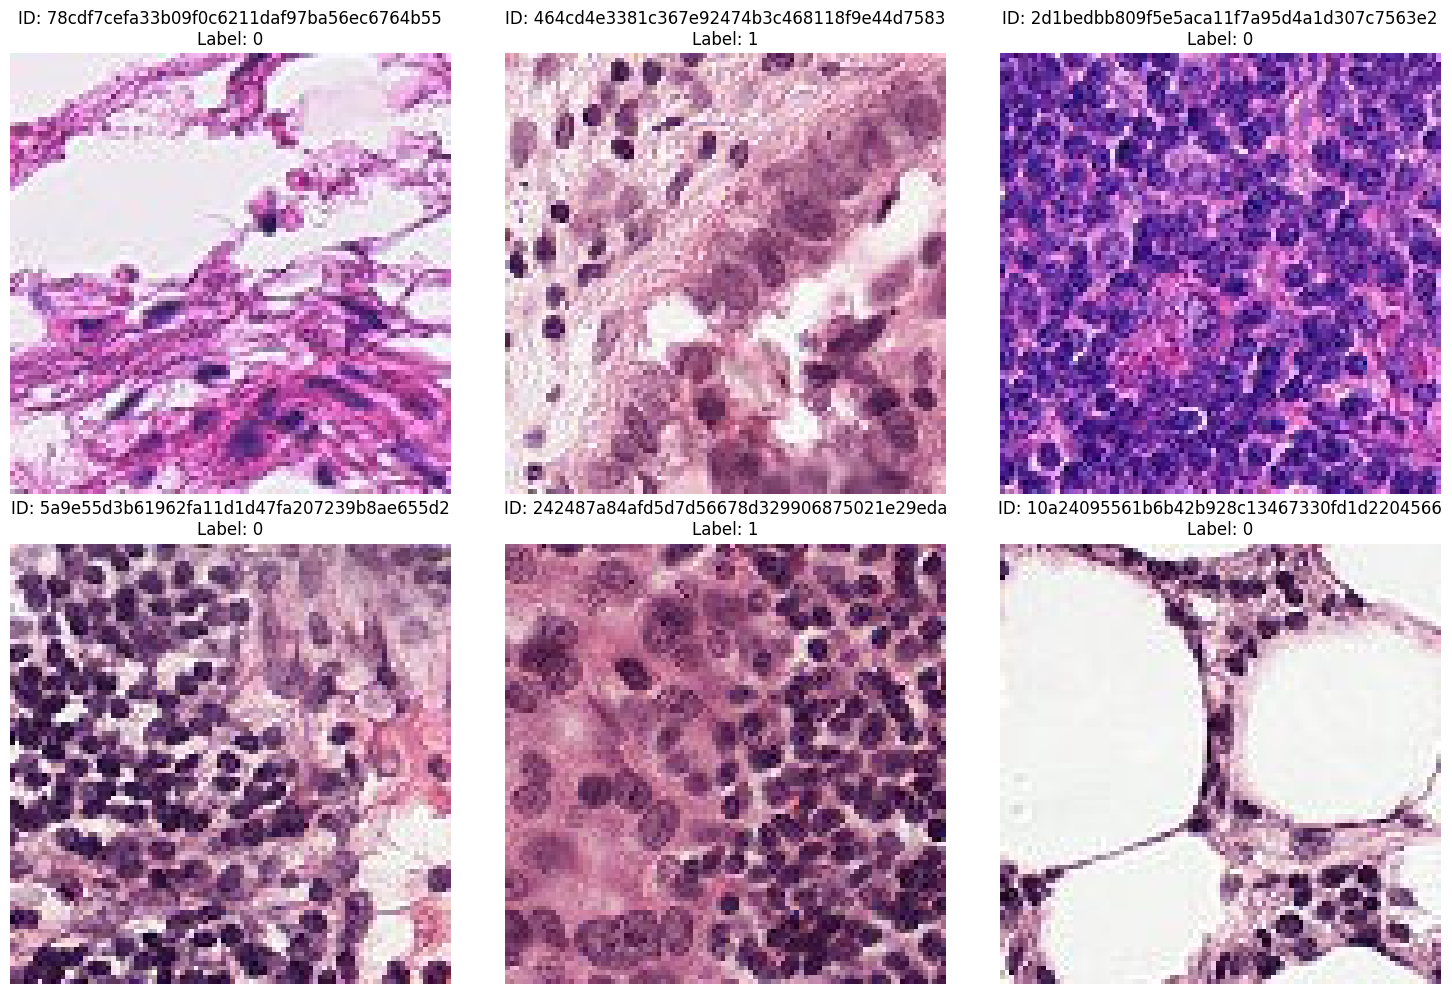

In [3]:
# inspecting 6 random raw images in the training dataset
import random
random.seed(20231113)
random_train_ids = random.sample(list(df_train['id']), 6)
random_train_labels = [df_train[df_train['id'] == img_id]['label'].values[0] for img_id in random_train_ids]
view_images(random_train_ids,random_train_labels,train_path)
print("6 random raw images in the training dataset:")

### 3. Exploratory Data Analysis (EDA)
After the EDA below, I found out that the training set dataframe, df_train, did not contain any null or duplicated values. It is pretty clean. Besides, this dataset is quite balanced since it contains 130908 label 0, which takes up about 59% of the dataset, and 89117 label 1, which is about 41% of the dataset. Thus, I did not do any cleaning for df_train.

As for the image data, I found out that they have the same size, with hight 96 and width 96, so I did not need to resize them. They are all in color mode 'RGB,' which did not require color mode change. The training dataset is very large, with 220025 images, and seems to be diverse in the random samples. Thus, I did not perform image augmentation. Overall, the image data is clean, very large, and seemingly diverse. However, due to my limited computer resources when training the models in later sections, I had to cut the run time by feeding them with a subset of the training data, instead of trying to resize the images to a lower resolution to reduce computational load which could decrease the prediction power of the model. I randomly sampled 1000 instances of the 220025 images in the training image data, assuming the random samples being representative of the entire trainging dataset. Then I splitted this subset into a training subset, subset_train_df, with 800 images, and a validation subset, subset_val_df, with 200 images. I double checked that they both roughly retain the 59-41 class ratio of the original training set, df_train. Both subset_train_df and subset_val_df have a 60-40 class ratio for label 0 and 1. The images in these two subsets were then normalized from range [0, 255] to range [0, 1] through the preprocess_images function, which also helped speed up the model training process.

### 3.1 EDA for the Dataframe of the Training Dataset

In [4]:
# checking data type and null values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [5]:
# checking for duplicated data in the training dataset
train_duplicates = df_train.duplicated().sum()
print("number of duplicated data in the training dataset:", train_duplicates)

number of duplicated data in the training dataset: 0


In [6]:
# getting simple statistics of each feature in the training dataset
df_train.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


number of samples for each class: label
0    130908
1     89117
Name: count, dtype: int64 

class ratios: label
0    0.594969
1    0.405031
Name: count, dtype: float64 



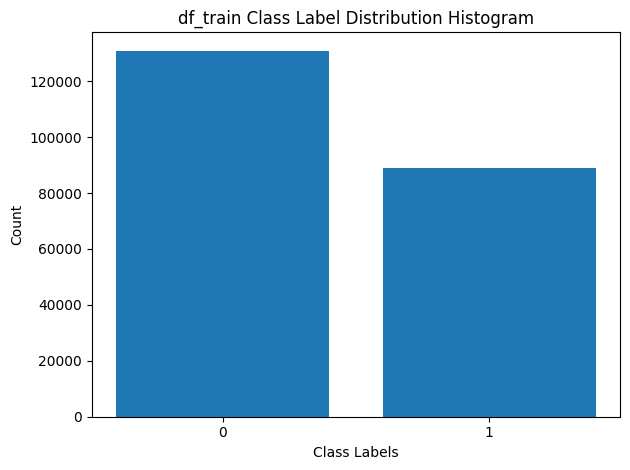

In [7]:
## checking if df_train is balanced or imbalanced
# computing number of samples for each class and class ratio
class_labels = df_train['label']
class_counts = class_labels.value_counts()
class_ratios = class_counts/class_counts.sum()
print("number of samples for each class:", class_counts, "\n")
print("class ratios:", class_ratios, "\n")

# creating class distribution histogram
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('df_train Class Label Distribution Histogram')
plt.xticks([0, 1]) 
plt.tight_layout()

### 3.2 EDA for the Images in the Training Dataset: Image Preprocessing

In [8]:
# checking image size of random samples
num_samples = 100
random.seed(20231113)

all_train_image_files = os.listdir(train_path)
sampled_train_image_files = random.sample(all_train_image_files, num_samples)

image_dimensions = set()
color_modes = set()
for image_file in sampled_train_image_files:
    with Image.open(os.path.join(train_path, image_file)) as img:
        image_dimensions.add(img.size)
        color_modes.add(img.mode)

print("Sampled image dimensions in the dataset:", image_dimensions)
print("Sampled color modes in the dataset:", color_modes)

Sampled image dimensions in the dataset: {(96, 96)}
Sampled color modes in the dataset: {'RGB'}


In [9]:
## data splitting
# ensuring the IDs end with '.tif'
df_train['id'] = df_train['id'].apply(lambda x: x if x.endswith('.tif') else x + '.tif')

# sampling a subset of df_train
subset_df = df_train.sample(n=1000, random_state=20231114)

# splitting the sampled subset into training and validation sets
from sklearn.model_selection import train_test_split
subset_train_df, subset_val_df = train_test_split(subset_df, test_size=0.2, random_state=20231114)
print("df_train.shape =", df_train.shape)
print("subset_train_df.shape =", subset_train_df.shape)
print("subset_val_df.shape =", subset_val_df.shape)

df_train.shape = (220025, 2)
subset_train_df.shape = (800, 2)
subset_val_df.shape = (200, 2)


number of samples for each class: label
0    479
1    321
Name: count, dtype: int64 

class ratios: label
0    0.59875
1    0.40125
Name: count, dtype: float64 



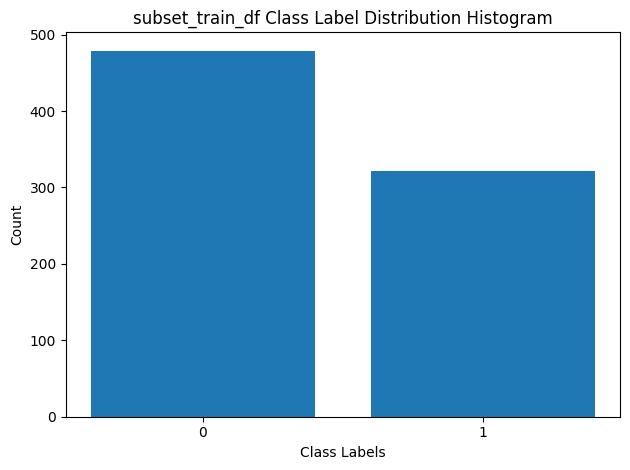

In [10]:
# checking if subset_train_df is balanced or imbalanced
# also checking it it retains the original class ratio
class_labels = subset_train_df['label']
class_counts = class_labels.value_counts()
class_ratios = class_counts/class_counts.sum()
print("number of samples for each class:", class_counts, "\n")
print("class ratios:", class_ratios, "\n")

# creating class distribution histogram
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('subset_train_df Class Label Distribution Histogram')
plt.xticks([0, 1]) 
plt.tight_layout()

number of samples for each class: label
0    119
1     81
Name: count, dtype: int64 

class ratios: label
0    0.595
1    0.405
Name: count, dtype: float64 



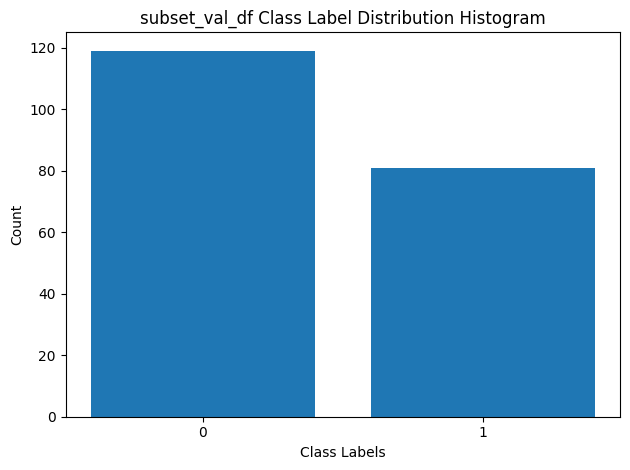

In [11]:
# checking if subset_val_df is balanced or imbalanced
# also checking it it retains the original class ratio
class_labels = subset_val_df['label']
class_counts = class_labels.value_counts()
class_ratios = class_counts/class_counts.sum()
print("number of samples for each class:", class_counts, "\n")
print("class ratios:", class_ratios, "\n")

# creating class distribution histogram
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('subset_val_df Class Label Distribution Histogram')
plt.xticks([0, 1]) 
plt.tight_layout()

In [12]:
# creating a function to load and preprocess images
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
def preprocess_images(df, path):
    images = []
    for img_id in df['id'].values:
        img = load_img(os.path.join(path, img_id), target_size=(96, 96))
        img = img_to_array(img) / 255.0  # normalizing images from range [0, 255] to range [0,1]
        images.append(img)
    return np.array(images)

In [13]:
# preprocessing the images for the randomly sampled training subset and the validation subset
train_images = preprocess_images(subset_train_df, train_path)
train_labels = subset_train_df['label'].values
val_images = preprocess_images(subset_val_df, train_path)
val_labels = subset_val_df['label'].values

### 4. Model Building, Training, Optimizing, and Evaluating

### 4.1 ImageNet_ANN_full_model
The ImageNet_ANN_full_model is a hybrid model of ImageNet_CNN and ANN_classifier, as decribed in the first section. Its ImageNet_CNN has the following architecture: <br>
input layer <br>
-> {convolution layer 1 -> convolution layer 2 -> maxpooling layer}*2 <br>
-> {convolution layer 1 -> convolution layer 2 -> convolution layer 3 -> maxpooling layer}*3 <br>

These feature extraction base layers are all pretrained in the Vgg16 model with ImageNet trained weights. The reason why I used Vgg16 and ImageNet instead of other pretrained model is that Vgg16 is easily accessible in the Keras Tuner library and that ImageNet is well trained with large and diverse image data. Besides, this kind of transfer learning worked in previous studies of medical image data (see referece section).

Then the ImageNet_CNN layers are fed into an ANN classifier with the following architecture: <br>
global average pooling <br> -> dense layer with ReLU activation function and best number of neurons = 96 <br> -> dropout layer with best dropout rate = 0.1 <br> -> optimizer layer using Adam with loss = binary-crossentropy, metrics = accuracy, and best learning rate = 0.01 <br> -> dense layer with 1 neuron and sigmoid activation function <br>

Beside the "best" hyperparameters, results from hyperparameter tuning using the Keras Tuner Hyperband, the other hyperparameters are set with specific reasons. In the first dense layer, its activation function ReLu is chosen since it makes the neural network learn fast without suffering severely from the vanishing gradient problem like some other functions. The dropout layer is added to prevent overfitting. The optimizer Adam is used here because it is efficient for large datasets and parameters. It has a binary corss entropy loss function which suits the binary class image classification task of this project. Similarly, the sigmoid activation function in the last dense layer with the one binary output neuron is chosen for it outputs values in range [0, 1], which suits the project's task well.

I cut the epochs to 2 to cut the run time because of my limited computer resource, as mentioned before. I also applied early stopping for faster iteration and to avoid overfitting.

The training subset AUC of this model turns out to be 0.5544; while, its validation subset AUC is 0.5519. These AUC scores are not so good, but at least there seems to be no overfitting in this model.

Note that for some unsolvable bugs, I gave up using the val_auc objective in the hyperparameter tuning process. Instead, I used val_accuracy. 

In [14]:
import keras_tuner as kt
from keras_tuner import Hyperband
from keras_tuner import Objective
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
## ImageNet_CNN_full_model building
# convolutional base layers: pretrained with ImageNet, which won't be tuned
# an instance of transfer learning

print("The ImageNet_CNN' architecture is the following:")
ImageNet_CNN = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
ImageNet_CNN.summary()

The ImageNet_CNN' architecture is the following:
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool

In [16]:
## ImageNet_ANN_full_model building and preparing for hyperparameter tuning
# adding top layers and preparing for hyperparameter tuning
# the hyperparameters wrapped with hp.x() are the ones to be tuned later
 
def build_ImageNet_ANN_full_model(hp):
    ## the ImageNet_CNN
    base_model = ImageNet_CNN
    base_model.trainable = False
    
    ## the ANN_classifier
    # reducing the dimensions and total number of parameters of the convolutional base ImageNet_model
    # to help prevent overfitting
    x = GlobalAveragePooling2D()(base_model.output)
    
    # adding a fully connected layer with a common large numbers of neurons
    # to learn complex patterns
    x = Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(x)
    
    # adding a dropout layer with a common dropout rate
    # to prevent overfitting
    x = Dropout(rate=hp.Float('dropout', min_value=0, max_value=0.5, step=0.1))(x)
    
    # adding an output layer with 1 neuron
    # to predict the classification label (0 or 1) of the input images
    predictions = Dense(1, activation='sigmoid')(x)
    
    ## ImageNet_CNN + ANN_classifier
    ImageNet_ANN_full_model = Model(inputs=base_model.input, outputs=predictions)
    ImageNet_ANN_full_model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
                  #metrics=['accuracy', AUC(name='auc')])
    
    return ImageNet_ANN_full_model

In [17]:
## ImageNet_ANN_full_model hyperparameter tuning using the Hyperband tuner from the Keras Tuner library
# to optimize a the ImageNet_ANN_full_model for maximum validation accuracy i.e. 'val_accuracy'
# initializing the tuner
tuner = Hyperband(build_ImageNet_ANN_full_model,
                  #objective = Objective("val_auc", direction="max"),
                  objective = "val_accuracy",
                  max_epochs = 2, # reduced for a faster iteration
                  directory ='hyperparam_tuning',
                  project_name='histopathologic_cancer_detection',
                  factor = 3,  # default value
                  seed = 20231115)

# starting hyperparameter search
tuner.search(train_images, train_labels,
             validation_data=(val_images, val_labels),
             epochs = 3,
             callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
             verbose = 2)
             # applied early stopping for a faster iteration and to avoid overfitting

# getting the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [18]:
# results of the tuner above
tuner.results_summary()

Results summary
Results in hyperparam_tuning/histopathologic_cancer_detection
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0003 summary
Hyperparameters:
units: 96
dropout: 0.1
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8589065074920654

Trial 0002 summary
Hyperparameters:
units: 384
dropout: 0.4
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8106650114059448

Trial 0000 summary
Hyperparameters:
units: 64
dropout: 0.30000000000000004
learning_rate: 0.0001
tuner/epochs: 1
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/engine/base_tuner.py", line 261, in _run_and_

In [19]:
## updating ImageNet_ANN_full_model with the best hyperparameters
best_units = best_hps.get('units')
best_dropout = best_hps.get('dropout')
best_learning_rate = best_hps.get('learning_rate')

# rebuilding the model with the best hyperparameters
ImageNet_CNN = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# freezing the layers of the VGG16 model
for layer in ImageNet_CNN.layers:
    layer.trainable = False

# adding new top layers using the best hyperparameters
x = GlobalAveragePooling2D()(ImageNet_CNN.output)
x = Dense(best_units, activation='relu')(x)
x = Dropout(best_dropout)(x)
predictions = Dense(1, activation='sigmoid')(x)

# creating the updated model
ImageNet_ANN_full_model = Model(inputs=ImageNet_CNN.input, outputs=predictions)

# compiling the updated model
ImageNet_ANN_full_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
                                loss='binary_crossentropy',
                                metrics=['accuracy', AUC(name='auc')])

print("The hyperparameters tuned in the top layers are the following:")
print("Best number of neurons in the dense layer:", best_units)
print("Best dropout rate in the dropout layer:", best_dropout, "\n")

print("The hyperparameter tuned in the optimizer is the following:")
print("Best learning rate in the Adam optimizer when compiling the model:", best_learning_rate, "\n")

print("The ImageNet_ANN_full_model's architecture with best hyperparameters is the following:")
ImageNet_ANN_full_model.summary()

The hyperparameters tuned in the top layers are the following:
Best number of neurons in the dense layer: 96
Best dropout rate in the dropout layer: 0.1 

The hyperparameter tuned in the optimizer is the following:
Best learning rate in the Adam optimizer when compiling the model: 0.01 

The ImageNet_ANN_full_model's architecture with best hyperparameters is the following:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
               

In [20]:
## ImageNet_ANN_full_model training AUC score inspecting
# calculating the AUC score of subset_train_df
from sklearn.metrics import roc_auc_score

ImageNet_ANN_full_model_train_predictions = ImageNet_ANN_full_model.predict(train_images)
ImageNet_ANN_full_model_train_auc = roc_auc_score(train_labels, ImageNet_ANN_full_model_train_predictions)

print("ImageNet_ANN_full_model Training AUC:", ImageNet_ANN_full_model_train_auc)

25/25 [==============================] - 39s 2s/step
ImageNet_ANN_full_model Training AUC: 0.5544260823756658


In [21]:
## ImageNet_ANN_full_model validation AUC score inspecting
# calculating the AUC score of subset_val_df
ImageNet_ANN_full_model_validation_predictions = ImageNet_ANN_full_model.predict(val_images)
ImageNet_ANN_full_model_validation_auc = roc_auc_score(val_labels, ImageNet_ANN_full_model_validation_predictions)

print("ImageNet_ANN_full_model Validation AUC:", ImageNet_ANN_full_model_validation_auc)

7/7 [==============================] - 10s 1s/step
ImageNet_ANN_full_model Validation AUC: 0.5519244734931009


### 4.2 ImageNet_SVM_full_model
The ImageNet_SVM_full_model is a hybrid model of ImageNet_CNN and SVM_classifier, as decribed in the first section. Its ImageNet_CNN has the following architecture: <br>
input layer <br>
-> {convolution layer 1 -> convolution layer 2 -> maxpooling layer}*2 <br>
-> {convolution layer 1 -> convolution layer 2 -> convolution layer 3 -> maxpooling layer}*3 <br>

These feature extraction base layers are all pretrained in the Vgg16 model with ImageNet trained weights. The reason why I used Vgg16 and ImageNet instead of other pretrained model is that Vgg16 is easily accessible in the Keras Tuner library and that ImageNet is well trained with large and diverse image data. Besides, this kind of transfer learning worked in previous studies of medical image data (see referece section). This part is the same as in the first model, ImageNet_ANN_full_model.

Then the ImageNet_CNN layers are fed into an SVM classifier with best hyperparameters C= 1000, gamma = 0.0001, and kernel = poly. These "best" hyperparameters are from the results of hyperparameter tuning using GridSearchCV.

The training subset AUC of this model turns out to be 0.9137; while, its validation subset AUC is 0.8073. These AUC scores are pretty good, but there might be some not-too-sever overfitting in this model.

In [22]:
## ImageNet_SVM_full_model building
# convolutional base layers, same as the one in ImageNet_ANN_full_model: pretrained with ImageNet, which won't be tuned
# an instance of transfer learning

print("The Imagenet_CNN' architecture is the following:")
Imagenet_CNN = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
Imagenet_CNN.summary()

The Imagenet_CNN' architecture is the following:
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool

In [23]:
## ImageNet_SVM_full_model building
# building the SVM classifier

from tensorflow.keras.applications import VGG16
import numpy as np

# using the Imagenet_CNN convolutional base layers to extract features
train_features = Imagenet_CNN.predict(train_images)
val_features = Imagenet_CNN.predict(val_images)

# flattening the features to feed into the SVM classifier
train_features_flattened = train_features.reshape(train_features.shape[0], -1)
val_features_flattened = val_features.reshape(val_features.shape[0], -1)

7/7 [==============================] - 10s 1s/step


In [24]:
## ImageNet_SVM_full_model hyperparameter tuning
# hyperparameter tuning for the SVC classifier with 5-fold cross-validations using GridSearchCV

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1000, 10000], 'gamma': [0.00001, 0.0001], 'kernel': ['rbf', 'poly']} 
svm = SVC()

ImageNet_SVM_full_model = GridSearchCV(svm, param_grid, cv=5)
ImageNet_SVM_full_model.fit(train_features_flattened, train_labels)

print("Best SVM hyperparameters:", ImageNet_SVM_full_model.best_params_)
print("Best SVM cross-validation score:", ImageNet_SVM_full_model.best_score_)

Best SVM hyperparameters: {'C': 1000, 'gamma': 0.0001, 'kernel': 'poly'}
Best SVM cross-validation score: 0.8099999999999999


In [25]:
## ImageNet_SVM_full_model training AUC score inspecting
# calculating the AUC score of subset_train_df
ImageNet_SVM_full_model_train_predictions = ImageNet_SVM_full_model.predict(train_features_flattened)
ImageNet_SVM_full_model_train_auc = roc_auc_score(train_labels, ImageNet_SVM_full_model_train_predictions)

print("ImageNet_SVM_full_model Training AUC Score:", ImageNet_SVM_full_model_train_auc)

ImageNet_SVM_full_model Training AUC Score: 0.9137026125299982


In [26]:
## ImageNet_SVM_full_model validation AUC score inspecting
# calculating the AUC score of subset_val_df
ImageNet_SVM_full_model_validation_predictions = ImageNet_SVM_full_model.predict(val_features_flattened)
ImageNet_SVM_full_model_validation_auc = roc_auc_score(val_labels, ImageNet_SVM_full_model_validation_predictions)

print("ImageNet_SVM_full_model Validation AUC Score:", ImageNet_SVM_full_model_validation_auc)

ImageNet_SVM_full_model Validation AUC Score: 0.8073451602863367


### 5. Results and Analysis 
The second hybrid model ImageNet_SVM_full_model, performs much better than the first one, the ImageNet_ANN_full_model, because it has a much better training and validation AUC score, as mentioned in the previous sections. <br>

However, we should keep in mind that I did not use the entire, very large training dataset but fed my models with 800 randomly sampled training images and 200 validation images in the models. This could potential cause some overfitting and inaccuracy in the models' prediction power.

In [27]:
print("ImageNet_ANN_full_model Training AUC:", ImageNet_ANN_full_model_train_auc)
print("ImageNet_ANN_full_model Validation AUC:", ImageNet_ANN_full_model_validation_auc)
print("ImageNet_SVM_full_model Training AUC Score:", ImageNet_SVM_full_model_train_auc)
print("ImageNet_SVM_full_model Validation AUC Score:", ImageNet_SVM_full_model_validation_auc)

ImageNet_ANN_full_model Training AUC: 0.5544260823756658
ImageNet_ANN_full_model Validation AUC: 0.5519244734931009
ImageNet_SVM_full_model Training AUC Score: 0.9137026125299982
ImageNet_SVM_full_model Validation AUC Score: 0.8073451602863367


### 6. Compiling the Prediction Results from the Best Performing Model: ImageNet_SVM_full_model
Since the ImageNet_SVM_full_model is the best performing one in my project, I compiled a pandas dataframe, df_test, for the test dataset images, with 57458 rows, and two columns: 'id,' storing each image file name in the test dataset, and 'label,' storing their corresponding classification label, 0 or 1. Among all the test images, 36577 of them are labeled as 0 and 20881 as 1, as predicted by the model. It has a class ratio of about 64-36. Then 6 random images (with predicted labels) are inspected. As a lay person, I cannot tell whether or not the model made correct predictions for these images, but it was nice to see inspect the outputs of this model. Finally, the df_test dataframe is outputted as an csv file for submission. 

In [28]:
# preparing the test set images
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

def preprocess_test_images(path):
    image_files = [file for file in os.listdir(path) if file.endswith('.tif')]
    images = []

    for img_id in image_files:
        img = load_img(os.path.join(path, img_id), target_size=(96, 96))
        img = img_to_array(img) / 255.0  # normalizing images
        images.append(img)

    return np.array(images)

test_images = preprocess_test_images(test_path)

In [29]:
# ImageNet_SVM_full_model test set predictions
test_features = ImageNet_CNN.predict(test_images)
test_features_flattened = test_features.reshape(test_features.shape[0], -1)
ImageNet_SVM_full_model_test_predictions = ImageNet_SVM_full_model.predict(test_features_flattened)

1796/1796 [==============================] - 2897s 2s/step


In [30]:
# creating a dataframe to store the test image ids in 'id' and their prediction labels in 'label'

# function to extract file names from the test path
def get_image_ids(path):
    image_ids = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('.tif')]
    return image_ids

# extracting test image ids
test_image_ids = get_image_ids(test_path)

# creating df_test
df_test = pd.DataFrame({
    'id': test_image_ids,
    'label': ImageNet_SVM_full_model_test_predictions
})

In [32]:
print("df_test.shape =", df_test.shape)
print("df_test.head:")
df_test.head()

df_test.shape = (57458, 2)
df_test.head:


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


number of samples for each class: label
0    36577
1    20881
Name: count, dtype: int64 

class ratios: label
0    0.636587
1    0.363413
Name: count, dtype: float64 



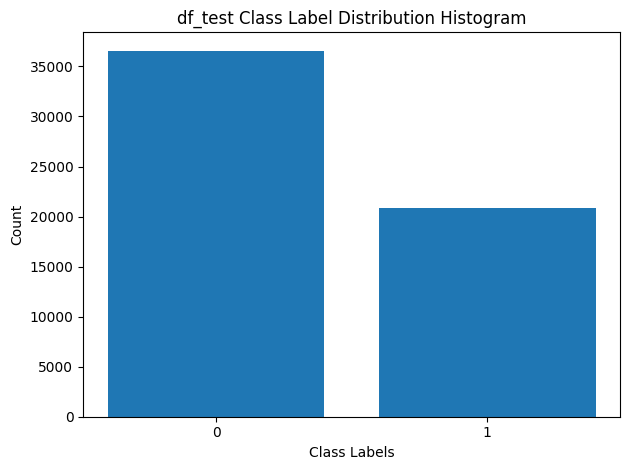

In [33]:
# checking whether or not df_test is balanced or imbalaced
class_labels = df_test['label']
class_counts = class_labels.value_counts()
class_ratios = class_counts/class_counts.sum()
print("number of samples for each class:", class_counts, "\n")
print("class ratios:", class_ratios, "\n")

# creating class distribution histogram
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('df_test Class Label Distribution Histogram')
plt.xticks([0, 1]) 
plt.tight_layout()

6 random raw images in the test dataset:


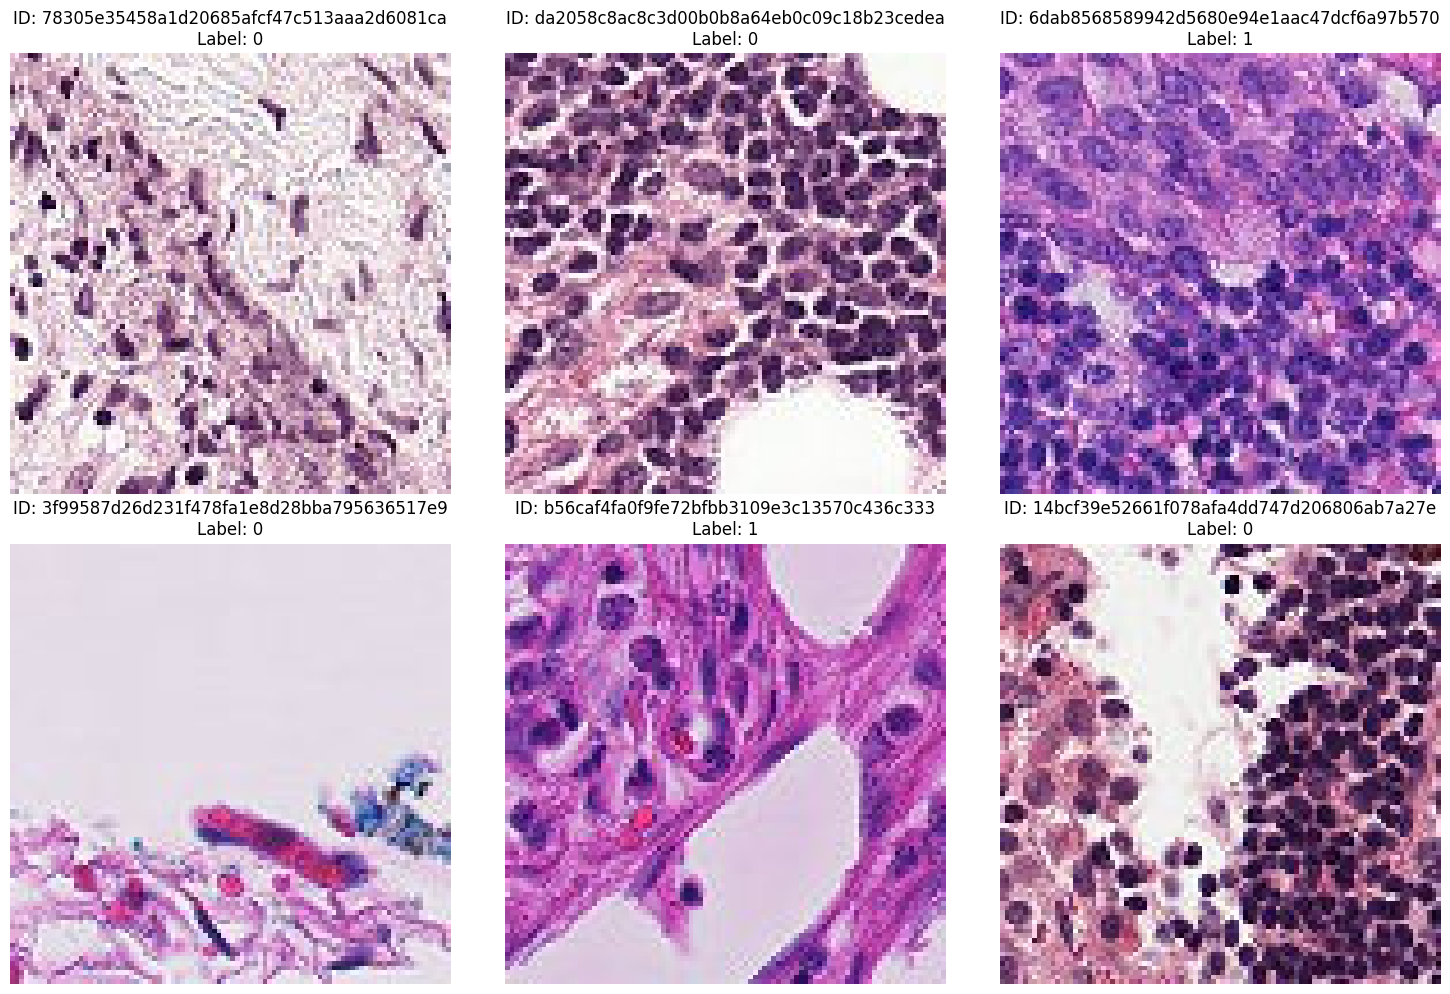

In [34]:
# inspecting 6 random raw images in the test dataset
import random
random.seed(20231115)
random_test_ids = random.sample(list(df_test['id']), 6)
random_test_labels = [df_test[df_test['id'] == img_id]['label'].values[0] for img_id in random_test_ids]
view_images(random_test_ids,random_test_labels,test_path)
print("6 random raw images in the test dataset:")

In [35]:
# creating an output file of df_test for Kaggle competition submission
output_file_path = '/kaggle/working/TsaiYunLi_HCD_submission.csv'
df_test.to_csv(output_file_path, index=False)

### 6. Conclusion and Limitations
The ImageNet_ANN_full_model, a hybrid model of ImageNet_CNN and ANN_classifier has a training subset AUC of 0.5544, and a validation subset AUC of 0.5519, which are not so good, but at least that there seems to be no overfitting in this model. While, ImageNet_SVM_full_model, a hybrid model of ImageNet_CNN and SVM_classifier, has a training subset AUC of 0.9137, and a validation subset AUC of 0.8073, much better than the ones of the first model. Thus, I used ImageNet_SVM_full_model to predict the test images' labels, which turns out to have a test dataset AUC of 0.7804, a score for the Kaggle leaderboard position of about 1068. This score is not bad but also not ideal. This might be caused by the fact that, due to limited computer resources, I did not feed the entire, very large training dataset but 800 randomly sampled training images and 200 validation images in the model during its training phase. This could potentially cause some overfitting and inaccuracy in the models' prediction power. Also because of the limitation on computer resource, when predicting labels for the entire 57458 test images , it took a long time to run on the Kaggle notebook environment. It ran 1796 iterations with 2s/step and 2897s in total, which is a crazy long time. 

If I were to redo this project, instead of using Kaggle notebook with limited computer resource, I would try to figure out how to input the Kaggle datasets from a local environment of a computer with many GPUs or a cloud environment for unlimited computation power. When the computation resource limitation is lifted, my models would probably make better predictions and score higher.

Please point out what else I need to adjust to improve my model's prediction power. Your suggestions and advice are very welcomed!

### 7. References
Kaggle competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview <br>
Kaggle data: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data <br>
Image visualization: https://www.geeksforgeeks.org/working-with-images-in-python-using-matplotlib/ <br>
Image preprocessing: https://www.section.io/engineering-education/image-preprocessing-in-python/ <br>
Image normalization or rescaling: https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/ <br>
Transfer learning for medical image classification: a literature review: https://bmcmedimaging.biomedcentral.com/articles/10.1186/s12880-022-00793-7#:~:text=97,2019%3B101%3A101743 <br>
Keras Tuner: https://www.tensorflow.org/tutorials/keras/keras_tuner <br>
SVM in sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html